In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy as sp
from scipy.integrate import odeint
import random
import matplotlib.cm as cm
from typing import Callable


In [19]:
def A_matrix_calculator(matrix_parameters):

    """
    Generate an N x N real matrix S with
      E[S_ij] = s/N,
      Var(S_ij) = sigma**2 / N,
      Cov(S_ij, S_ji) = gamma * sigma**2 / N  for i != j.

    Parameters
    ----------
    N : int
        Matrix size.
    s : float
        Controls the mean: mean = s/N.
    sigma : float
        Standard-deviation scale (the variance will be sigma**2 / N).
    gamma : float
        Correlation between S_ij and S_ji; must satisfy -1 <= gamma <= 1.
    seed : int or None
        RNG seed for reproducibility.

    Returns
    -------
    S : (N, N) ndarray
        Real matrix with the specified second-moment structure.
    """
    N, s, sigma, gamma, seed = matrix_parameters
    if not (-1.0 <= gamma <= 1.0):
        raise ValueError("gamma must lie in [-1, 1] for a valid covariance matrix.")

    rng = np.random.default_rng(seed)
    mu = s / N
    var = sigma**2 / N
    cov = gamma * var

    # covariance matrix for a bivariate normal for (S_ij, S_ji)
    covmat = np.array([[var, cov],
                       [cov, var]])

    S = np.empty((N, N), dtype=float)

    # Fill diagonal: independent normal with mean mu and variance var
    S[np.diag_indices(N)] = 0

    # Indices for strict upper triangle (i < j)
    iu, ju = np.triu_indices(N, k=1)
    m = len(iu)
    if m > 0:
        # draw m bivariate normals
        draws = rng.multivariate_normal(mean=[mu, mu], cov=covmat, size=m)
        # assign to (i,j) and (j,i)
        S[iu, ju] = draws[:, 0]
        S[ju, iu] = draws[:, 1]
    # print(S)
    return S

def dndt(t, n_arr, N, r, k, migration, s, sigma, gamma, seed):
    matrix_parameters = (N, s, sigma, gamma, seed)
    A_matrix = A_matrix_calculator(matrix_parameters)
    interaction_terms = A_matrix.dot(n_arr)           
    n_dot_arr = (r / k) * (k * n_arr - n_arr**2) - interaction_terms * n_arr + migration
    return n_dot_arr

def solver(N, t_span, t_eval, sigma, n_i_0, r=1.0, k=1.0, migration=1.0, s=1.0, gamma=0.5, seed=4254322132):
    args = (N, r, k, migration, s, sigma, gamma, seed)
    sol = solve_ivp(fun=lambda t, y: dndt(t, y, *args),
                    t_span=t_span,
                    y0=np.asarray(n_i_0, dtype=float),
                    t_eval=t_eval,
                    vectorized=False,
                    rtol=1e-6,
                    atol=1e-9)
    return sol


/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_1084/2197052527.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')                # choose 'tab10' or 'tab20'


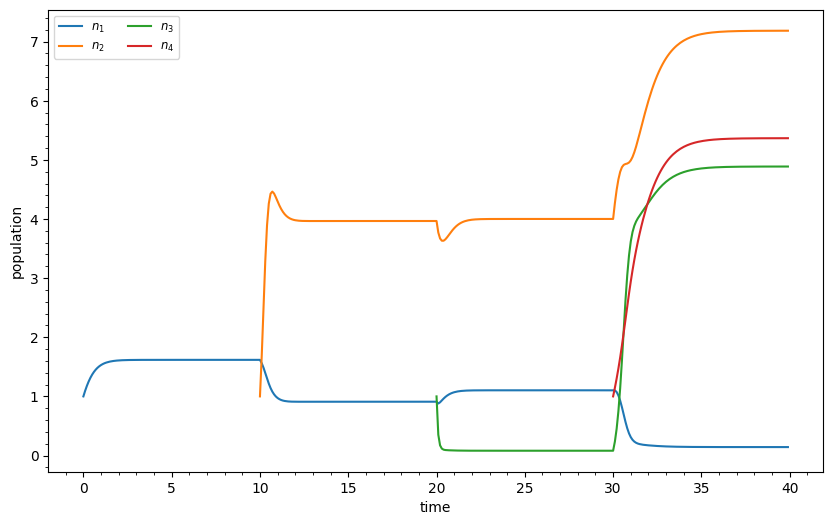

In [20]:
cmap = cm.get_cmap('tab10')                # choose 'tab10' or 'tab20'
def color_for_species(idx):
    return cmap(idx % cmap.N)
global_time = []
global_populations = None   # will be (n_time, species_count)
plotted = []  

dt = 0.1; time_per_block = 10; sigma = 2.5

N_total = 4; initial_species_value = 1
time_interval_array = np.linspace(0, time_per_block*N_total, N_total + 1)
species_arr = np.arange(1, N_total + 1)
initial_condition = 1; initial_conditions_tuple = (initial_condition)

addition_times = []
snapshots = []
for i in range(len(time_interval_array) - 1):
    current_N = i + 1      # number species in this block
    t0 = time_interval_array[i]
    t1 = time_interval_array[i + 1]
    t_eval = np.arange(t0, t1, dt)

    if i == 0:
        n0 = np.full(current_N, initial_species_value)
    else:
        
        prev_last = sol.y[:, -1]            
        addition_times.append(t0)           
        n0 = np.append(prev_last, initial_species_value)
    sol = solver(current_N, t_span=(t0, t1), t_eval=t_eval, sigma=sigma, n_i_0=n0)
    snapshots.append(sol.y[:, -1].copy())
    if global_populations is None:
        global_sim_time = sol.t.copy()
        global_populations = sol.y.T.copy()   
    else:
        global_sim_time = np.concatenate([global_sim_time, sol.t])
        prev_cols = global_populations.shape[1]
        if current_N > prev_cols:
            global_populations = np.hstack([global_populations, np.full((global_populations.shape[0], current_N - prev_cols), np.nan)])
        block_rows = sol.y.T
        if block_rows.shape[1] < global_populations.shape[1]:
            block_rows = np.hstack([block_rows, np.full((block_rows.shape[0], global_populations.shape[1] - block_rows.shape[1]), np.nan)])
        global_populations = np.vstack([global_populations, block_rows])

plt.figure(figsize=(10, 6))

num_species_reached = global_populations.shape[1]
for sidx in range(num_species_reached):
    color = color_for_species(sidx)
    label = f"$n_{sidx+1}$" if sidx not in plotted else None
    plt.plot(global_sim_time, global_populations[:, sidx], color=color, label=label)
    plotted.append(sidx)

plt.xlabel('time')
plt.ylabel('population')
plt.minorticks_on()
plt.legend(ncol=2, fontsize='small')
plt.show()



In [21]:
max_len = max(len(s) for s in snapshots)
n_events = len(snapshots)
snapshots_padded = np.full((n_events, max_len), np.nan, dtype=float)
for i, s in enumerate(snapshots):
    snapshots_padded[i, :len(s)] = s

species_arrays = [snapshots_padded[:, j].copy() for j in range(max_len)]
species_arrays = [i[~np.isnan(i)] for i in species_arrays]

print(species_arrays)

order_parameter = [sum((x[i+1] - x[i])**2 for i in range(len(x)-1)) for x in species_arrays]
print(order_parameter)

[array([1.6180337 , 0.91011214, 1.10305149, 0.14268198]), array([3.96638406, 4.00102933, 7.18457521]), array([0.08117896, 4.88776041]), array([5.36671686])]
[np.float64(1.4606881193585821), np.float64(10.13616463344231), np.float64(23.10322526386532), 0]


In [77]:
def order_parameter_calculator(N_total, std, plot):
    cmap = cm.get_cmap('tab10')                # choose 'tab10' or 'tab20'
    def color_for_species(idx):
        return cmap(idx % cmap.N)
    global_time = []
    global_populations = None   # will be (n_time, species_count)
    plotted = []  

    dt = 0.1; time_per_block = 10; sigma = std

    sigma_array = np.linspace(1, 100, 11)

    initial_species_value = 1
    time_interval_array = np.linspace(0, time_per_block*N_total, N_total + 1)
    species_arr = np.arange(1, N_total + 1)
    initial_condition = 1; initial_conditions_tuple = (initial_condition)

    addition_times = []
    snapshots = []
    for i in range(len(time_interval_array) - 1):
        current_N = i + 1      # number species in this block
        t0 = time_interval_array[i]
        t1 = time_interval_array[i + 1]
        t_eval = np.arange(t0, t1, dt)

        if i == 0:
            n0 = np.full(current_N, initial_species_value)
        else:
            
            prev_last = sol.y[:, -1]            
            addition_times.append(t0)           
            n0 = np.append(prev_last, initial_species_value)
        sol = solver(current_N, t_span=(t0, t1), t_eval=t_eval, sigma=sigma, n_i_0=n0)
        snapshots.append(sol.y[:, -1].copy())
        if global_populations is None:
            global_sim_time = sol.t.copy()
            global_populations = sol.y.T.copy()   
        else:
            global_sim_time = np.concatenate([global_sim_time, sol.t])
            prev_cols = global_populations.shape[1]
            if current_N > prev_cols:
                global_populations = np.hstack([global_populations, np.full((global_populations.shape[0], current_N - prev_cols), np.nan)])
            block_rows = sol.y.T
            if block_rows.shape[1] < global_populations.shape[1]:
                block_rows = np.hstack([block_rows, np.full((block_rows.shape[0], global_populations.shape[1] - block_rows.shape[1]), np.nan)])
            global_populations = np.vstack([global_populations, block_rows])

    if plot == True:
        plt.figure(figsize=(10, 6))

        num_species_reached = global_populations.shape[1]
        for sidx in range(num_species_reached):
            color = color_for_species(sidx)
            label = f"$n_{sidx+1}$" if sidx not in plotted else None
            plt.plot(global_sim_time, global_populations[:, sidx], color=color, label=label)
            plotted.append(sidx)

        plt.xlabel('time')
        plt.ylabel('population')
        plt.minorticks_on()
        plt.legend(ncol=2, fontsize='small')
        plt.yscale('log')
        plt.show()

    max_len = max(len(s) for s in snapshots)
    n_events = len(snapshots)
    species_snapshots = np.full((n_events, max_len), np.nan, dtype=float)
    for i, s in enumerate(snapshots):
        species_snapshots[i, :len(s)] = s
    # print("species snapshots =", species_snapshots)

    species_arrays = [species_snapshots[:, j].copy() for j in range(max_len)]
    species_arrays = [i[~np.isnan(i)] for i in species_arrays]
    # for i in species_arrays:
    #     np.insert(i, 0, initial_species_value, axis = 1) 
    species_arrays = np.array([np.insert(arr, 0, initial_species_value) for arr in species_arrays], dtype=object)

    # print("Species array =", species_arrays)
    order_parameter = np.mean([sum((x[i+1] - x[i])**2 for i in range(len(x)-1)) for x in species_arrays])
    # print("order parameter array =", order_parameter_array)
    # order_parameter = order_parameter_array)
    # print()
    return order_parameter

    

/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_1084/1358375797.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')                # choose 'tab10' or 'tab20'


[ 1.18253376  1.25554459  1.33207381  1.41245049  1.49705197  1.58630942
  1.6807157   1.78083378  1.88730893  2.00088267  2.12241047  2.25289218
  2.39348835  2.54557768  2.71079429  2.89111263  3.08895543  3.3073261
  3.5500205   3.82193001  4.12947087  4.48122537  4.88889436  5.36868377
  5.94331483  6.64474761  7.51761372  8.62267914 10.03946128 11.86803054]


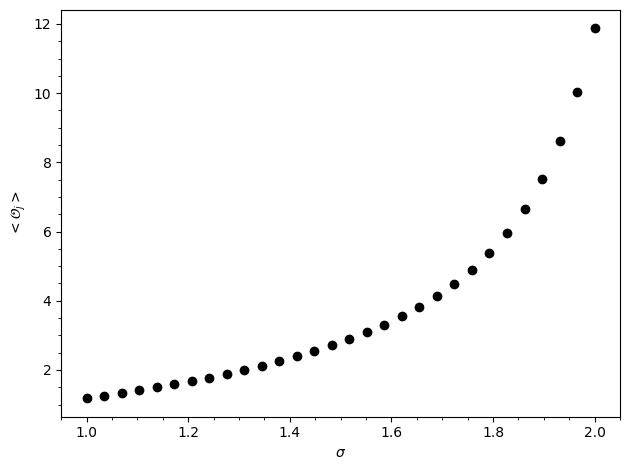

In [85]:
std_array = np.linspace(1, 2, 30)

final = []
for i in range(len(std_array)):
    # print(order_parameter_calculator(4, std_array[i], False))
    final.append(order_parameter_calculator(7, std_array[i], False))

final = np.array(final)

print(final)

plt.plot(std_array, final, 'ko')

plt.xlabel(r"$\sigma$")
plt.ylabel(r"$<\mathcal{O}_{j}>$")
# plt.legend()
plt.minorticks_on()
plt.tight_layout()
# plt.yscale('log')
plt.show()
